In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, feature
from skimage.transform import resize, rotate
import scipy.io as sio # to read in the .mat files
from sklearn.model_selection import train_test_split
import re

# used to import the image folders
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

from PIL import Image, ImageOps
from tensorflow.keras.models import Model
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization

from keras.applications.imagenet_utils import preprocess_input, decode_predictions


Goals 3/18/21:
- Understand what is given in the train and test data.
- What do the numbers in the target stand for?
    - Create a dictionary that allocates key to dog


From Stanford Dog Dataset <http://vision.stanford.edu/aditya86/ImageNetDogs/>
```
Features (train_data.mat, test_data.mat):
 - train_data/test_data
   -- contains the feature matrix after histogram intersection kernel has been applied
 - train_fg_data/test_fg_data
   -- contains the feature matrix before applying the histogram intersection kernel
 - train_info/test_info
   -- contains the labels and ids for the corresponding image in the feature matrix
```

<details><summary>How 'extras/train_data.mat' looks: (CLICK)</summary>

```
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Mar 28 12:03:37 2012',
 '__version__': '1.0',
 '__globals__': [],
 'train_info': array([[(array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
        [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
        [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
       dtype=object), array([[array(['n02085620-Chihuahua/n02085620_5927'], dtype='<U34')],
        [array(['n02085620-Chihuahua/n02085620_4441'], dtype='<U34')],
        [array(['n02085620-Chihuahua/n02085620_1502'], dtype='<U34')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_6754'], dtype='<U44')],
        [array(['n02116738-African_hunting_dog/n02116738_9333'], dtype='<U44')],
        [array(['n02116738-African_hunting_dog/n02116738_2503'], dtype='<U44')]],
       dtype=object), array([[  1],
        [  1],
        [  1],
        ...,
        [120],
        [120],
        [120]], dtype=uint8), array([[array(['histograms_spm/n02085620-Chihuahua/n02085620_5927.mat'],
       dtype='<U53')],
        [array(['histograms_spm/n02085620-Chihuahua/n02085620_4441.mat'],
       dtype='<U53')],
        [array(['histograms_spm/n02085620-Chihuahua/n02085620_1502.mat'],
       dtype='<U53')],
        ...,
        [array(['histograms_spm/n02116738-African_hunting_dog/n02116738_6754.mat'],
       dtype='<U63')],
        [array(['histograms_spm/n02116738-African_hunting_dog/n02116738_9333.mat'],
       dtype='<U63')],
        [array(['histograms_spm/n02116738-African_hunting_dog/n02116738_2503.mat'],
       dtype='<U63')]], dtype=object))]],
       dtype=[('file_list', 'O'), ('annotation_list', 'O'), ('labels', 'O'), ('fg_ids', 'O')]),
 'train_fg_data': array([[4.32900433e-04, 2.88600289e-04, 2.88600289e-04, ...,
         3.96825397e-04, 3.24675325e-04, 2.30880231e-03],
        [0.00000000e+00, 6.34920635e-04, 6.98412698e-04, ...,
         1.90476190e-04, 3.17460317e-05, 4.09523810e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.42465753e-04, 8.56164384e-05, 1.28424658e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.72817460e-03, 1.43849206e-03, 4.96031746e-05],
        [1.92307692e-04, 9.61538462e-05, 9.61538462e-05, ...,
         6.25000000e-04, 4.80769231e-05, 6.73076923e-04],
        [3.84985563e-04, 0.00000000e+00, 0.00000000e+00, ...,
         4.04234841e-03, 4.81231954e-05, 3.36862368e-04]]),
 'train_data': array([[1.        , 0.37021212, 0.38627623, ..., 0.21216631, 0.33752761,
         0.26825407],
        [0.37021212, 1.        , 0.45434285, ..., 0.14359524, 0.3095    ,
         0.17709522],
        [0.38627623, 0.45434285, 1.        , ..., 0.16968838, 0.28702648,
         0.20437348],
        ...,
        [0.21216631, 0.14359524, 0.16968838, ..., 1.        , 0.22314713,
         0.41941136],
        [0.33752761, 0.3095    , 0.28702648, ..., 0.22314713, 1.        ,
         0.31585238],
        [0.26825407, 0.17709522, 0.20437348, ..., 0.41941136, 0.31585238,
         1.        ]])}
```
</details>

<details><summary>How 'extras/lists/train_list.mat' looks: (CLICK)</summary>

```
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:36:13 2011',
 '__version__': '1.0',
 '__globals__': [],
 'file_list': array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
        [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
        [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
       dtype=object),
 'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_5927'], dtype='<U34')],
        [array(['n02085620-Chihuahua/n02085620_4441'], dtype='<U34')],
        [array(['n02085620-Chihuahua/n02085620_1502'], dtype='<U34')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_6754'], dtype='<U44')],
        [array(['n02116738-African_hunting_dog/n02116738_9333'], dtype='<U44')],
        [array(['n02116738-African_hunting_dog/n02116738_2503'], dtype='<U44')]],
       dtype=object),
 'labels': array([[  1],
        [  1],
        [  1],
        ...,
        [120],
        [120],
        [120]], dtype=uint8)}
```
</details>

### Using the train_list.mat file seems to be a bit easier to understand (less 0s need to be added in to find the file; labels in another portion of dictionary)

In [44]:
train_dict = sio.loadmat('extras/lists/train_list.mat')

loop through and add in file pathway (extras/images/)
change 4th 0 to i
1st 0 stands for an array containing the image path -- CHANGE
Last two 0s indicate the first part of arrray (image path) -- KEEP

store this in a list...?

train_imgs = []

for i in range(len(train_dict['file_list'])):

    train_imgs.append('extras/images/' + train_dict['train_info'][i][0][0])

In [130]:
# Make above code as a function so we can use for test data
def add_file_path(dict_key):
    '''
    Adds file path to the image
    Parameter:
    dict_key: dictionary key - value is an array (with an array inside, which contains the image path)
    Variable passed should be from the train_list.mat or test_list.mat
    '''
    imgs = []
    for i in range(len(dict_key)):
        imgs.append('extras/images/' + dict_key[i][0][0])
    return imgs

In [131]:
train_imgs = add_file_path(train_dict['file_list'])

In [132]:
# did it work?
train_imgs

['extras/images/n02085620-Chihuahua/n02085620_5927.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_4441.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_1502.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_1916.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_13151.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_1569.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_9654.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_3975.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_3942.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_9351.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_574.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_4998.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_7.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_1617.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_11140.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_5771.jpg',
 'extras/images/n02085620-Chihuahua/n02085620_275.jpg',
 'extras/images/n02085620-Chihuahu

In [48]:
train_imgs[0][0]

'extras/images/n02085620-Chihuahua/n02085620_5927.jpg'

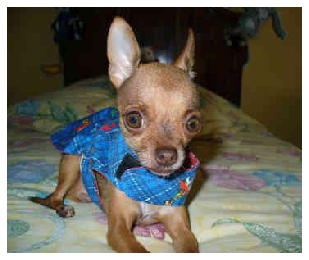

In [49]:
chihuahua = io.imread(train_imgs[0][0])
io.imshow(chihuahua)
plt.axis('off');

In [133]:
X_train, X_test, y_train, y_test = train_test_split(train_dict['file_list'], train_dict['labels'], test_size = 0.2, stratify = train_dict['labels'], random_state = 5)

In [134]:
# use regex to create list of breed names
breeds = []
for i in np.unique(train_dict['labels']):
    # get one file - first 0 is just first file with the label
    # second 0 is just the file path
    file = X_train[y_train ==i][0][0]
    # regex pattern
    # n[0-9]+- denotes a pattern that starts with n, has the group 0-9 an unknown amount of times and a hyphen
    # OR a pattern that starts with non-whitespace (\W for the forward slash), n[0-9]+, an underscore
    # [0-9] some amount of times and ends with .jpg
    pattern = re.compile(r'n[0-9]+-|\Wn[0-9]+_[0-9]+.jpg')
    # replace this pattern for each file with an empty string and append to breeds list
    breeds.append(pattern.sub('', file))

In [58]:
# create empty dictionary for labels
breed_key = dict()
for i in np.unique(train_dict['labels']):
    # labels start at 1, so to match python idx, subtract 1 from breeds
    breed_key[i] = breeds[i-1]

In [59]:
breed_key

{1: 'Chihuahua',
 2: 'Japanese_spaniel',
 3: 'Maltese_dog',
 4: 'Pekinese',
 5: 'Shih-Tzu',
 6: 'Blenheim_spaniel',
 7: 'papillon',
 8: 'toy_terrier',
 9: 'Rhodesian_ridgeback',
 10: 'Afghan_hound',
 11: 'basset',
 12: 'beagle',
 13: 'bloodhound',
 14: 'bluetick',
 15: 'black-and-tan_coonhound',
 16: 'Walker_hound',
 17: 'English_foxhound',
 18: 'redbone',
 19: 'borzoi',
 20: 'Irish_wolfhound',
 21: 'Italian_greyhound',
 22: 'whippet',
 23: 'Ibizan_hound',
 24: 'Norwegian_elkhound',
 25: 'otterhound',
 26: 'Saluki',
 27: 'Scottish_deerhound',
 28: 'Weimaraner',
 29: 'Staffordshire_bullterrier',
 30: 'American_Staffordshire_terrier',
 31: 'Bedlington_terrier',
 32: 'Border_terrier',
 33: 'Kerry_blue_terrier',
 34: 'Irish_terrier',
 35: 'Norfolk_terrier',
 36: 'Norwich_terrier',
 37: 'Yorkshire_terrier',
 38: 'wire-haired_fox_terrier',
 39: 'Lakeland_terrier',
 40: 'Sealyham_terrier',
 41: 'Airedale',
 42: 'cairn',
 43: 'Australian_terrier',
 44: 'Dandie_Dinmont',
 45: 'Boston_bull',
 46

In [140]:
path_X_train = add_file_path(X_train)
path_X_valid = add_file_path(X_test)

In [136]:
path_X_train

['extras/images/n02104029-kuvasz/n02104029_4815.jpg',
 'extras/images/n02088364-beagle/n02088364_13050.jpg',
 'extras/images/n02088238-basset/n02088238_2217.jpg',
 'extras/images/n02096051-Airedale/n02096051_1669.jpg',
 'extras/images/n02112350-keeshond/n02112350_10100.jpg',
 'extras/images/n02094433-Yorkshire_terrier/n02094433_1219.jpg',
 'extras/images/n02091032-Italian_greyhound/n02091032_12013.jpg',
 'extras/images/n02088466-bloodhound/n02088466_1671.jpg',
 'extras/images/n02106550-Rottweiler/n02106550_7430.jpg',
 'extras/images/n02110063-malamute/n02110063_14141.jpg',
 'extras/images/n02108915-French_bulldog/n02108915_481.jpg',
 'extras/images/n02105056-groenendael/n02105056_1523.jpg',
 'extras/images/n02086079-Pekinese/n02086079_4843.jpg',
 'extras/images/n02109047-Great_Dane/n02109047_8139.jpg',
 'extras/images/n02097298-Scotch_terrier/n02097298_809.jpg',
 'extras/images/n02086910-papillon/n02086910_4330.jpg',
 'extras/images/n02097047-miniature_schnauzer/n02097047_2917.jpg',
 '

In [66]:
# transfer learning model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [68]:
# Make Sequential Model out of the base VGG16 Model
analyzer_model = Sequential()

for layer in vgg16_model.layers[:-1]:
    analyzer_model.add(layer)
    
# Sequential Model almost the same as VGG16 model, but no input or predictions layer

In [65]:
# freeze layers that have already been trained
for layer in analyzer_model.layers[:-1]:
    layer.trainable = False

In [95]:
# add final prediction layer (dense) to predict the 120 classes
analyzer_model.add(Dense(120, activation = 'relu'))

In [96]:
analyzer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

To do:
- Resize images to be 244 x 244
- Add predictions layer

In [105]:
# compile model
optimizer = Adam(lr = 0.0001)
analyzer_model.compile(optimizer = optimizer,
                      loss = categorical_crossentropy,
                      metrics = ['accuracy'])

In [146]:
analyzer_model.fit(np.array(real_X_train), y_train, 
                   validation_data = (np.array(real_X_valid), y_test))

ValueError: in user code:

    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/belindanguyen/opt/anaconda3/envs/py3_TF2.0/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 1) and (32, 120) are incompatible


In [86]:
# load in data; change shape to be same size as first layer
eskimo2_ = image.load_img('extras/images/n02109961-Eskimo_dog/n02109961_3054.jpg', target_size = (224, 224))

# change photo to array of pixels
eskimo2_arr = image.img_to_array(eskimo2_)

# reshape data for the model - now a tensor
eskimo2_arr = eskimo2_arr.reshape((1, eskimo2_arr.shape[0], eskimo2_arr.shape[1], eskimo2_arr.shape[2]))

In [90]:
eskimo2_arr = preprocess_input(eskimo2_arr)

In [91]:
yhat = vgg16_model.predict(eskimo2_arr)

In [138]:
new_X_train[0][0]

'extras/images/n02104029-kuvasz/n02104029_4815.jpg'

In [142]:
real_X_train = []

for i in range(len(path_X_train)):
    image1 = image.load_img(path_X_train[i], target_size = (224, 224))
    image1 = image.img_to_array(image1)
    image1 = imgage1.reshape((image1.shape[0], image1.shape[1], image1.shape[2]))
    real_X_train.append(image1)

In [143]:
real_X_valid = []

for i in range(len(path_X_valid)):
    image1 = image.load_img(path_X_valid[i], target_size = (224, 224))
    image1 = image.img_to_array(image1)
    image1 = imgage1.reshape((image1.shape[0], image1.shape[1], image1.shape[2]))
    real_X_valid.append(image1)

In [127]:
y_train.shape

(9600, 1)

In [129]:
np.array(real_X_train).shape

(9600, 224, 224, 3)

Having trouble training the data T_T
Ask for help on Sunday or something

In [152]:
class_names = []
# use regex to create list of breed names
for i in np.unique(train_dict['labels']):
    # get one file - first 0 is just first file with the label
    # second 0 is just the file path
    file = X_train[y_train ==i][0][0]
    # regex pattern
    # n[0-9]+- denotes a pattern that starts with n, has the group 0-9 an unknown amount of times and a hyphen
    # OR a pattern that starts with non-whitespace (\W for the forward slash), n[0-9]+, an underscore
    # [0-9] some amount of times and ends with .jpg
    pattern = re.compile(r'\Wn[0-9]+_[0-9]+.jpg')
    # replace this pattern for each file with an empty string and append to breeds list
    breeds.append(pattern.sub('', file))

In [153]:
images = image_dataset_from_directory('extras/Images', image_size = (224, 224),
                                      class_names = class_names, batch_size = 5)

Found 20580 files belonging to 120 classes.
